## Import Packages and Data

In [0]:
#@markdown Import dependencies
import pandas as pd
import torch
import cv2

import torch
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms


from torch.nn import functional as F
from torch import nn, optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [0]:
#@markdown Mount Drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#@markdown Specify global vars
DATA_DIR = './drive/My Drive/MLHC Project Resources/python_code/files/chex-ray-14'
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device = {device}")


Device = cuda


In [0]:
#@markdown Check what files we actually have on our google drive
files = os.listdir(DATA_DIR)
img_ids = [file for file in files if '.png' in file]
print(f"Number of Images on Google Drive: {len(img_ids)}")

Number of Images on Google Drive: 10015


In [0]:
#@markdown Class for CheXRayData
class ChestXrayDataSet(Dataset):
    def __init__(self, data_dir, list_of_image_list_file, subset_img_ids, transform=None):
        """
        Args:
            data_dir: path to image directory.
            list_of_image_list_file:  list of paths to the file containing images
                with corresponding labels.
            subset_img_ids: a subset of images that we actually have
            transform: optional transform to be applied on a sample.
        """
        image_names = []
        labels = []
        for image_list_file in list_of_image_list_file:
          with open(image_list_file, "r") as f:
              for line in f:
                  items = line.split()
                  image_name= items[0]
                  if image_name in subset_img_ids:
                      label = items[1:]
                      label = [int(i) for i in label]
                      image_name = os.path.join(data_dir, image_name)
                      image_names.append(image_name)
                      labels.append(label)

        self.image_names = image_names
        self.labels = labels
        if transform is not None:
            self.transform = transform
        else:
            self.transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                 transforms.Resize((224,224)),
                                                transforms.ToTensor()])

    def __getitem__(self, index):
        """
        Args:
            index: the index of item
        Returns:
            image and its labels
        """
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)

## Train VAE

In [0]:
#@markdown Global Variables
DIM = 224
LATENT_DIM = 60
test_dataset = ChestXrayDataSet(data_dir = DATA_DIR,
                            list_of_image_list_file = [DATA_DIR + '/train_list.txt',
                                               DATA_DIR + '/val_list.txt',
                                               DATA_DIR + '/test_list.txt'],
                            subset_img_ids = img_ids, 
                            transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                            transforms.Resize((DIM,DIM)),
                                                            transforms.ToTensor()]))

In [0]:
#@markdown VAE Class
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(DIM * DIM, 500)
        self.fc21 = nn.Linear(500, LATENT_DIM)
        self.fc22 = nn.Linear(500, LATENT_DIM)
        self.fc3 = nn.Linear(LATENT_DIM, 500)
        self.fc4 = nn.Linear(500, DIM * DIM)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, DIM*DIM))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, DIM*DIM), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD



In [0]:
#@markdown Helper functions for saving and loading a model
from datetime import datetime

def save_model(model, model_name = "vae", suffix = None):
  if suffix is None:
    timestamp = datetime.now().strftime("%d-%b-%Y (%H:%M:%S.%f)")
    model_save_name = f'{model_name}_{timestamp}.pt'
  else:
    model_save_name = f'{model_name}_{suffix}.pt'
  path = F"./drive/My Drive/MLHC Project Resources/python_code/vae_models/{model_save_name}" 
  torch.save(model.state_dict(), path)
  print(f"Model saved to {path}")
  return

def load_model(model_save_name):
  path = F"./drive/My Drive/MLHC Project Resources/python_code/vae_models/{model_save_name}.pt" 
  model = VAE()
  model.load_state_dict(torch.load(path))
  print(f"Model successfully loaded from {path}")
  model.to(device)
  return model

In [0]:
#@markdown Train VAE
BATCH_SIZE = 64
NUM_EPOCHS = 25

test_loader = DataLoader(dataset=test_dataset, batch_size= BATCH_SIZE, shuffle=False, pin_memory=False)

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.train()

# Print every number of batches
print_per = 1
epoch_save = 5
print(f"Training for {NUM_EPOCHS} epochs with batch size  {BATCH_SIZE} ")

for epoch in range(NUM_EPOCHS):
    train_loss = 0
    print_loss = 0
    for i, (inp, target) in enumerate(test_loader):
        inp = inp.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(inp)
        loss = loss_function(recon_batch, inp, mu, logvar)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        train_loss += loss.item()
        print_loss += loss.item()
        optimizer.step()
        #print( f"Loss for batch {i} = {train_loss} ")
        if (i%print_per == 0):
              print("Epoch : {} , Minibatch : {} Loss = {:.4f}".format(epoch+1, i, print_loss))
              # Overwrite print_loss
              print_loss = 0
    print("Epoch {} : Loss = ({:.4f}) ".format(epoch+1, train_loss))

    if epoch > 0:
      if (epoch%epoch_save == 5):
        save_model(model, model_name = f"vae_{dim}_epoch_{epoch}_A-12")
      


In [0]:
#save_model(model, model_name = "10k_vae60_dim224_epoch25_batch64_A-12")

## Finding Neighbors

In [0]:
#@markdown Load Model
#need to have cuda; check with: print(device)
model = load_model("10k_vae60_dim224_epoch25_batch64_A-12_09-May-2020 (18:54:22.919440)")

In [0]:
def get_latent_representations_and_labels(test_dataset, idx, model):
  images, labels = test_dataset[idx]
  mu,logvar = model.encode(images.to(device).view(-1, DIM*DIM))
  latent_representations = model.reparameterize(mu, logvar)
  return latent_representations.squeeze(), labels


In [0]:
import time
from tqdm import tqdm

N_EXAMPLES = 10000
N_LABELS = 14
latent_representation_tensor = torch.zeros((N_EXAMPLES,LATENT_DIM))
labels_tensor = torch.zeros((N_EXAMPLES,N_LABELS))
for i in tqdm(range(N_EXAMPLES)):
  latent_representation_tensor[i,:], labels_tensor[i,:] = get_latent_representations_and_labels(test_dataset,i,model)

100%|██████████| 10000/10000 [31:15<00:00,  5.33it/s]


In [0]:
from sklearn.metrics import pairwise_distances
import numpy as np

def compute_labels(index, labels_tensor):
  CLASS_NAMES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia','Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
  N_LABELS = len(CLASS_NAMES)
  if sum(labels_tensor[index,:]) == 0:
    return ["None"]
  else:
    return([CLASS_NAMES[i] for i in range(N_LABELS) if labels_tensor[index,i] == 1])

def compute_nearest_neighbours(latent_representation_tensor):
  distance_matrix = pairwise_distances(latent_representation_tensor.detach().numpy())
  np.fill_diagonal(distance_matrix, np.inf)
  nearest_neighbours = np.argsort(distance_matrix, axis = 1)[:,:5]
  NN_dict = {}
  for i in range(nearest_neighbours.shape[0]):
    neighbours_of_i = nearest_neighbours[i,:]
    NN_dict[i] = { n:compute_labels(n,labels_tensor) for n in neighbours_of_i} 
    NN_dict[i]["Condition"] = compute_labels(i, labels_tensor)
  return(NN_dict)


In [0]:
def compute_random_neighbours(latent_representation_tensor):
  NN_dict = {}
  for i in range(N_EXAMPLES):
    neighbours_of_i = np.random.randint(0,10000,5)
    NN_dict[i] = { n:compute_labels(n,labels_tensor) for n in neighbours_of_i} 
    NN_dict[i]["Condition"] = compute_labels(i, labels_tensor)
  return(NN_dict)

In [0]:
random_neighbors = compute_random_neighbours(latent_representation_tensor)

In [0]:
nearest_neighbors = compute_nearest_neighbours(latent_representation_tensor)

In [0]:
678: {3666: ['None'],
  5555: ['Atelectasis', 'Pneumothorax', 'Emphysema'],
  5557: ['Emphysema'],
  6190: ['Effusion'],
  923: ['Effusion'],

In [0]:
image, label = test_dataset[4693]

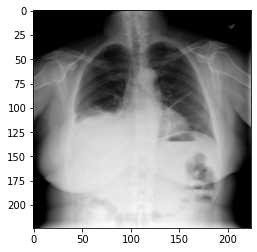

In [0]:
from google.colab import files as cofile

def get_reconstruction(image):
    return model(image.to(device))[0].cpu().detach().numpy().reshape(224,224)

sample_image = test_dataset[0][0]

def compare_true_to_reconstructed_image(image):
    recon = model(image.to(device))[0]
    #fig, ax = plt.subplots()
    #ax.imshow(image.squeeze(0), cmap ='gray')
    #fig(figsize=(1,1))
    plt.imshow(image.squeeze(0), cmap ='gray')
    #plt.savefig("368.png")
    #cofile.download("368.png")

    return

compare_true_to_reconstructed_image(image)

In [0]:
test_dataset.image_names[368]

'./drive/My Drive/MLHC Project Resources/python_code/files/chex-ray-14/00014706_029.png'

In [0]:
nearest_neighbors

{0: {1: ['None'],
  1835: ['None'],
  3210: ['None'],
  3268: ['None'],
  503: ['None'],
  'Condition': ['Pneumothorax']},
 1: {0: ['Pneumothorax'],
  1556: ['None'],
  503: ['None'],
  6219: ['None'],
  8509: ['Infiltration'],
  'Condition': ['None']},
 2: {150: ['None'],
  5015: ['None'],
  5231: ['None'],
  7295: ['None'],
  7904: ['None'],
  'Condition': ['Atelectasis']},
 3: {2343: ['None'],
  3195: ['None'],
  3469: ['Infiltration'],
  569: ['Consolidation'],
  8572: ['None'],
  'Condition': ['Nodule']},
 4: {5016: ['None'],
  6654: ['Infiltration'],
  8541: ['Edema'],
  8889: ['Atelectasis', 'Infiltration'],
  9509: ['None'],
  'Condition': ['None']},
 5: {7343: ['None'],
  808: ['None'],
  8572: ['None'],
  9380: ['Nodule'],
  9381: ['Mass', 'Nodule'],
  'Condition': ['None']},
 6: {194: ['None'],
  4: ['None'],
  8548: ['Pneumothorax'],
  9559: ['None'],
  9751: ['None'],
  'Condition': ['Atelectasis']},
 7: {2343: ['None'],
  2354: ['Atelectasis'],
  2367: ['None'],
  7044: [

## Evaluating Neighbors

In [0]:
#array of [condition, number of neighbors having same condition]
array_for_analysis = []
for i in range(len(nearest_neighbors)):
  neighbor = nearest_neighbors[i] #dict of neighborhood 
  condition = neighbor['Condition'] #condition (might be multiple)
  same_cond = -1
  for key in neighbor:
    if bool(set(condition) & set(neighbor[key])) : same_cond += 1 #if the set of a neighbor's conditions overlaps with the set of conditions, count it
  
  array_for_analysis.append([condition, same_cond])

In [0]:
array_for_analysis

In [0]:
 df_analysis = pd.DataFrame(array_for_analysis)
 df_analysis.columns = ['Condition', 'CountInNeighbors']

In [0]:
df_analysis['CountInNeighbors'].mean()

2.0285

In [0]:
df_analysis['CountInNeighbors'].std()

1.5226685791597112

In [0]:
df_analysis['Condition']

0                            [Pneumothorax]
1                                    [None]
2                             [Atelectasis]
3                                  [Nodule]
4                                    [None]
                       ...                 
9995                                 [None]
9996    [Atelectasis, Infiltration, Nodule]
9997                                 [None]
9998                          [Atelectasis]
9999                                 [None]
Name: Condition, Length: 10000, dtype: object

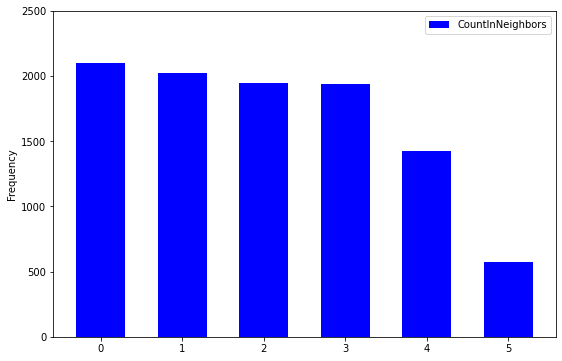

In [0]:
df_analysis[["CountInNeighbors"]].plot.hist(ylim=(0,2500), bins=(-.3,.3,.7,1.3,1.7,2.3,2.7,3.3,3.7,4.3,4.7,5.3), color = 'blue', grid=False, figsize=(9,6), rwidth=5)  # Note slicing is performed on df itself


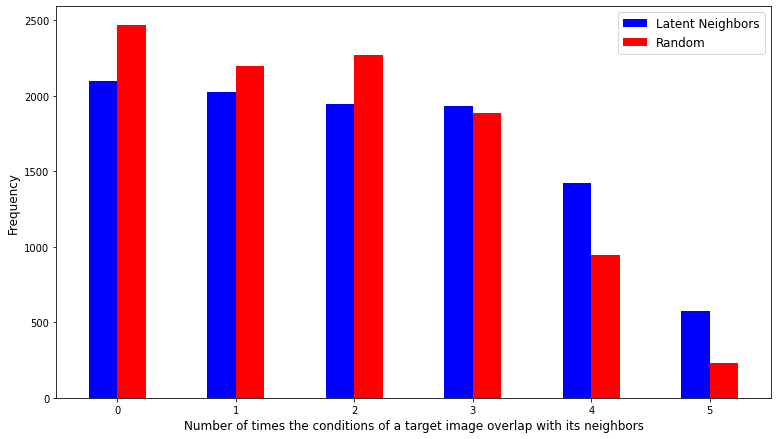

In [0]:
#ax = plt.hist(df_analysis["CountInNeighbors"], bins=, color = 'blue', rwidth=5, aplha = 0.4)
#ax.set_ylim([0, 2500])

from matplotlib import pyplot
bins = (-.3,.3,.7,1.3,1.7,2.3,2.7,3.3,3.7,4.3,4.7,5.3)
pyplot.figure(figsize=(12.8,7.2))

plt.hist([df_analysis["CountInNeighbors"], df_analysis2["CountInNeighbors"]], bins, color = ["blue", "red"], label=['Latent Neighbors', 'Random'])

#pyplot.hist(df_analysis["CountInNeighbors"], bins, color = 'blue', alpha=0.5, label='Latent Neighbors')
#pyplot.hist(df_analysis2["CountInNeighbors"], bins, color = 'red', alpha=0.5, label='Random')
pyplot.legend(loc='upper right', fontsize=12)

pyplot.xlabel("Number of times the conditions of a target image overlap with its neighbors", fontsize=12)
pyplot.ylabel("Frequency", fontsize=12)

pyplot.show()


In [0]:
#let's do the same for random 
#array of [condition, number of neighbors having same condition]
array_for_analysis2 = []
for i in range(len(random_neighbors)):
  neighbor = random_neighbors[i] #dict of neighborhood 
  condition = neighbor['Condition'] #condition (might be multiple)
  same_cond = -1
  for key in neighbor:
    if bool(set(condition) & set(neighbor[key])) : same_cond += 1 #if the set of a neighbor's conditions overlaps with the set of conditions, count it
  
  array_for_analysis2.append([condition, same_cond])

df_analysis2 = pd.DataFrame(array_for_analysis2)
df_analysis2.columns = ['Condition', 'CountInNeighbors']
df_analysis2['CountInNeighbors'].mean()

1.7334

In [0]:
df_analysis2['CountInNeighbors'].std()

1.382141624996182

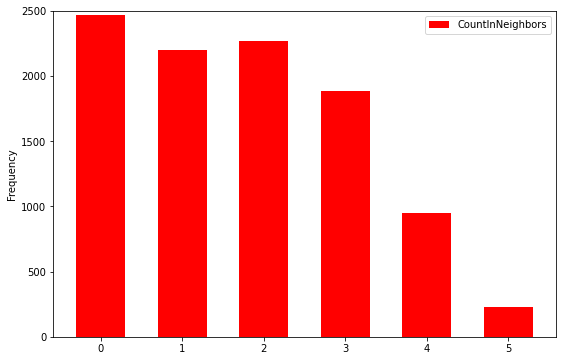

In [0]:
df_analysis2[["CountInNeighbors"]].plot.hist(ylim=(0,2500), bins=(-.3,.3,.7,1.3,1.7,2.3,2.7,3.3,3.7,4.3,4.7,5.3), color = 'red', grid=False, figsize=(9,6), rwidth=5)  # Note slicing is performed on df itself


### Other: (Disregard)

In [0]:
latent_representation_tensor[1]

tensor([ 2.4784, -0.9879,  0.0883, -0.9892, -2.5023, -1.4535,  0.7129, -0.9783,
         0.0836, -0.9444,  1.5272, -0.8284,  0.5284,  1.1252,  0.4566,  0.7286,
        -0.8266,  0.7266,  0.1814,  0.4352,  0.3237, -0.4580, -2.5858,  0.1451,
         0.1526,  0.6394, -1.0672, -0.0147, -1.6187, -4.4352,  2.3514,  0.7988,
        -0.2139, -1.8017, -0.8108,  0.6948,  1.1231,  1.2956, -0.2338, -0.5519,
        -0.7331,  1.6349,  0.4013, -0.7457, -0.1565,  1.2211, -0.9694,  0.8341,
        -0.0693, -0.7345, -2.0017, -1.6473, -0.7548,  1.3899,  1.5618, -0.9584,
        -0.0385, -0.2691, -1.1579,  1.4105], grad_fn=<SelectBackward>)

In [0]:
test_latent_repr = latent_representation_tensor[1]

In [0]:
test_latent_repr.shape

torch.Size([60])

In [0]:
for i in range(1, 61):
  hello = test_latent_repr * torch.tensor([0]*(i-1)+[100]*1+[0]*(60-i))
  reconstruction = model.decode(hello.to(device)).cpu().detach().numpy().reshape(224,224)
  fig, ax = plt.subplots(1)
  ax.imshow(reconstruction, cmap = 'gray')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
!pip install lime

In [0]:
import lime
import lime.lime_tabular

In [0]:
from sklearn.datasets import load_boston
import sklearn.ensemble
import numpy as np

In [0]:
boston = load_boston()
boston.data

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [0]:
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)

In [0]:
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(boston.data, boston.target, train_size=0.80)

In [0]:
train

array([[1.14600e-01, 2.00000e+01, 6.96000e+00, ..., 1.86000e+01,
        3.94960e+02, 7.73000e+00],
       [1.96091e+01, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.96900e+02, 1.34400e+01],
       [2.01019e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        3.69300e+02, 3.70000e+00],
       ...,
       [5.40110e-01, 2.00000e+01, 3.97000e+00, ..., 1.30000e+01,
        3.92800e+02, 9.59000e+00],
       [2.44668e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        8.86300e+01, 1.61400e+01],
       [6.90500e-02, 0.00000e+00, 2.18000e+00, ..., 1.87000e+01,
        3.96900e+02, 5.33000e+00]])

In [0]:
print(categorical_features)

[3 8]


In [0]:
rf.fit(train, labels_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
categorical_features = np.argwhere(np.array([len(set(boston.data[:,x])) for x in range(boston.data.shape[1])]) <= 10).flatten()
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=boston.feature_names, class_names=['price'], categorical_features=categorical_features, verbose=True, mode='regression')

In [0]:
i = 25
exp = explainer.explain_instance(test[i], rf.predict, num_features=5)

Intercept 26.27615041334859
Prediction_local [17.9674976]
Right: 14.710800000000004


In [0]:
exp.show_in_notebook(show_table=True)


In [0]:
explain_instance_with_data

In [0]:
hello = test_latent_repr * torch.tensor([1]*1+[0]*59)

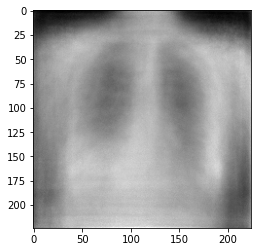

In [0]:
reconstruction = model.decode(hello.to(device)).cpu().detach().numpy().reshape(224,224)
fig, ax = plt.subplots(1)
ax.imshow(reconstruction, cmap = 'gray');

tensor([[ 1., -1.],
        [ 1., -1.]])

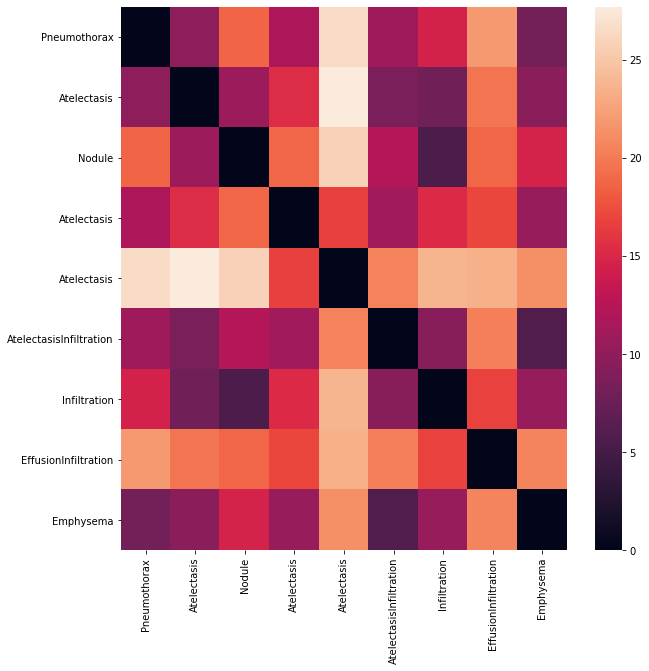

In [0]:
import seaborn as sns
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(distance_matrix[idx_plot,:][:,idx_plot],
            yticklabels = np.array(ls)[idx_plot],
            xticklabels = np.array(ls)[idx_plot])

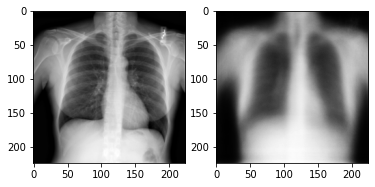

In [0]:
def get_reconstruction(image):
    return model(image.to(device))[0].cpu().detach().numpy().reshape(224,224)

sample_image = test_dataset[0][0]

def compare_true_to_reconstructed_image(image):
    recon = model(image.to(device))[0]
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image.squeeze(0), cmap ='gray');
    ax[1].imshow(get_reconstruction(image), cmap = 'gray');
    return

compare_true_to_reconstructed_image(sample_image)


In [0]:
model(sample_image.to(device))[0]

torch.Size([1, 50176])

In [0]:
for i in range(10):
  sample_image = test_dataset[i][0]
  compare_true_to_reconstructed_image(sample_image)



In [0]:
!pip install lime

In [0]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [0]:
!pip install pydicom

In [0]:
import torch
import torchvision
import pandas as pd
import cv2
import os

from torch.utils.data import Dataset
from PIL import Image

In [0]:
cd '/content/drive/My Drive/MLHC Project Resources/python_code/'

/content/drive/.shortcut-targets-by-id/107n_WmJFGDku3jDNPRYJskUDip3ElWv7/MLHC Project Resources/python_code


In [0]:
from load_model import *
from utils import *

In [0]:
model = load_model()

normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
transformer = transforms.Compose([transforms.Resize(256),
                                  transforms.TenCrop(224),
                                  transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                  transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))
                                ])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth



=> loading checkpoint
=> loaded checkpoint


In [0]:
def batch_image_predict(images):
    """
    Args:
        img_batch: list of 3-dimensional numpy array
    
    Global Variables:
        model: pre-trained model supplied by Alexandru
        transformer: pre-processing instance
    """
    pred_list = []

    for img in images:
      #convert np array to PIL.Image
      img_PIL = Image.fromarray(img).convert('RGB')

      #transform
      input_var = transformer(img_PIL)

      #predict, take the average of the predictions and save as np array
      output = model(input_var)
      output_mean = output.mean(0).detach().cpu().numpy()

      #store
      pred_list.append(output_mean)
    
    numpy_probs = np.stack(pred_list, axis=0)
    return numpy_probs

In [0]:
def explain_instance(img, img_diseases = None, num_samples = 5):
    """
    Args:
        img: the original 3-dimensional numpy array before transforming into torch tensor
        img_diseases: string of diseases for the image
        num_samples: 5 (the number of neighbours to consider)
    
    Global Variables:
        explainer: pre-defined explainer object
    """
    explanation = explainer.explain_instance(img,
                                             batch_image_predict,
                                             top_labels=5, 
                                             num_samples=num_samples)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=False, 
                                                num_features=10, 
                                                hide_rest=False)
    print(temp.shape)
    print(mask.shape)
    img_boundry2 = mark_boundaries(temp, mask)
    plt.imshow(img_boundry2)

    if img_diseases is not None:
        plt.title(f"Diseases: {img_diseases}")
        
    return

In [0]:
images, labels = test_dataset[1]

FileNotFoundError: ignored

In [0]:
explainer = lime_image.LimeImageExplainer()
explain_instance(img_np, num_samples = 10)